# This notebook generates figure 12, which proves that the correction method for critical current suppression does what is expected, i.e., tighten the data, as proven by the sum square of residuals. 

In [36]:
%pylab notebook
import sys, os, importlib, pandas as pd, seaborn as sns
from scipy.optimize import curve_fit

sys.path.append('lib/')
import hts_fitting as hts, hts_fitfunctions as ff, hts_misc as misc, default_figure_style as dfs, hts_beamspot as bsp
for lib in [hts, ff, misc, dfs, bsp]:
    importlib.reload(lib)

cols = [0, 1, 13, 14, 41, 53, 55, 56, 57, 58, 59]
names = ['tapeid', 'anneal', 'power', 'powerError', 'tTAR_OFF','degradation', 'suppression', 
         'suppressionError', 'suppression_corrected', 'suppressionError_corrected', 'outlier']
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)

########## Filter data ##########
#################################
cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1
data = df[cut]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Description of figure12

Here we show that our method effectively eliminates the difference between earlier power scans (less degradation) and later ones (more degradation). Test the method with ffj37 data.

<IPython.core.display.Javascript object>


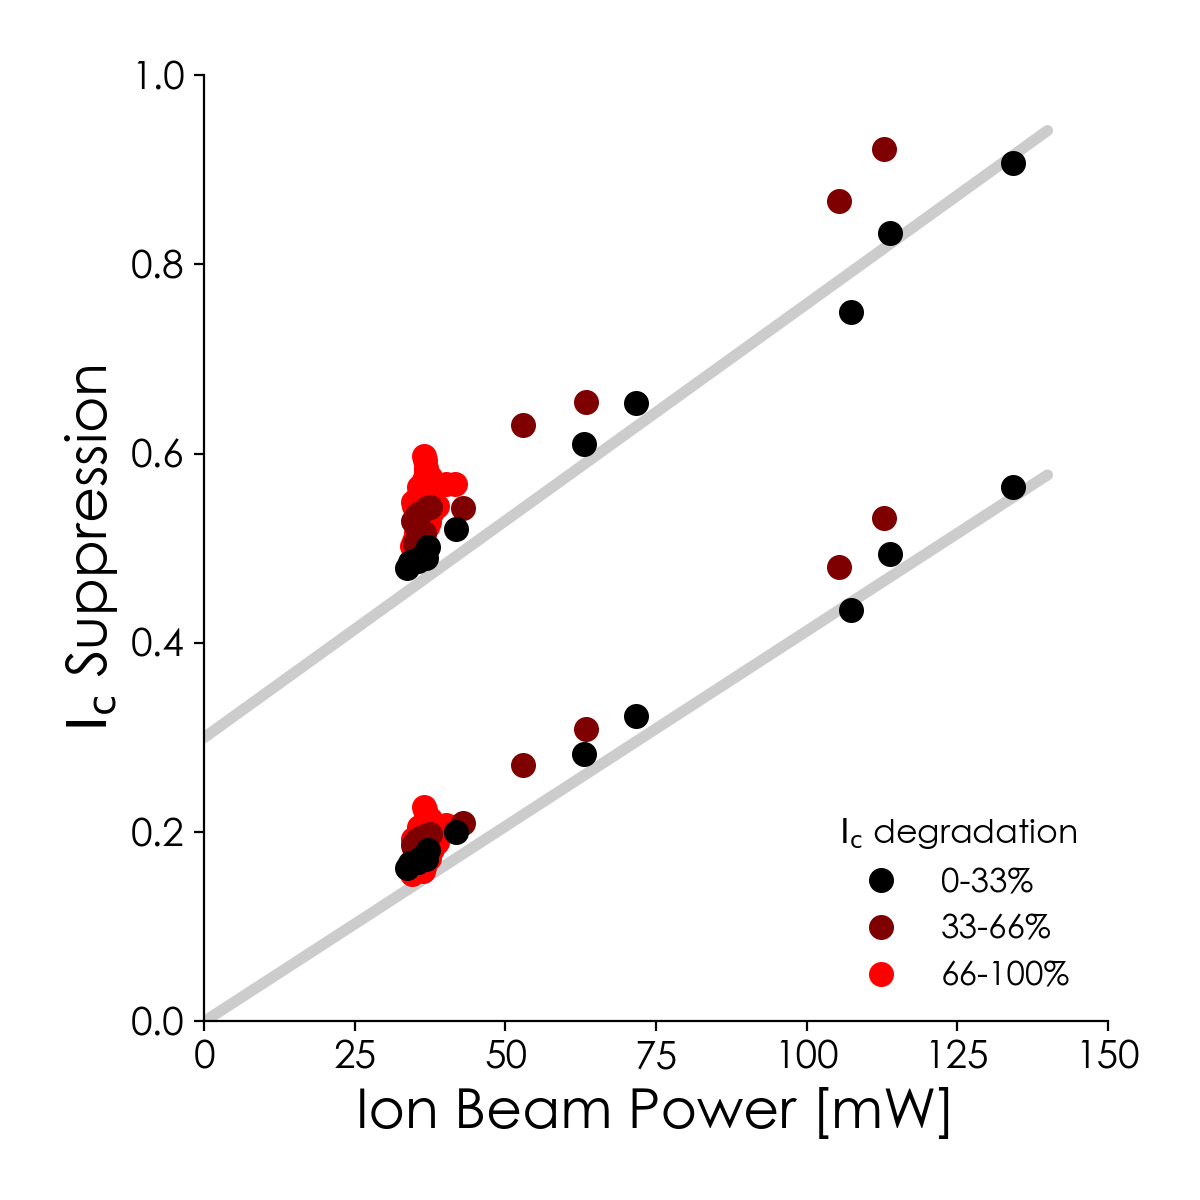

R$^2$ = 0.61
R$^2$ = 0.91


In [38]:
def getR2(x, y):
    popt, pcov = curve_fit(ff.affine, x, y)
    yfit = ff.affine(x, *popt)
    residuals = y - yfit
    ss_res, ss_tot = np.sum(residuals**2), np.sum((y - np.mean(y))**2)
    return 1 - (ss_res / ss_tot), popt

fig, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=True)

tapeid = 'f37'
  
x, ex = data.power, data.powerError
y, ey = data.suppression_corrected, data.suppressionError
z, ez = data.suppression, data.suppressionError

axes.set_xlabel('Ion Beam Power [mW]')
axes.set_ylabel('$\mathrm{I_c}$ Suppression')
#axes[1].set_ylabel('Corrected $\mathrm{I_c}$ Suppression')

cut = (data.tapeid == tapeid) & (data.anneal == 1)
for d, dy in zip([z, y], [.3, 0]):
    axes.set_ylim(0, 1.)
    axes.set_xlim(0, 150)
    rsq, popt = getR2(x[cut], d[cut])
    xsmooth = np.linspace(0, 140, 1000)
    ysmooth = ff.affine(xsmooth, *popt)
    axes.plot(xsmooth, ysmooth+dy, linewidth=4, color='k', alpha=.2, solid_capstyle='round')

    print('R$^2$ = '+'{:4.2f}'.format(rsq))

axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
    
nsegments = 5
pintervals = np.linspace(0, 1, nsegments)
palette = sns.color_palette('blend:red,black', 3)
labels = ['66-100%', '33-66%', '0-33%']
for p, c, l in zip(pintervals, palette, labels):
    cut = (p <= data.degradation) & (data.degradation <= p+1/nsegments) & (data.tapeid == tapeid) & (data.anneal == 1)
    if x[cut].count() > 0:
        axes.plot(x[cut], z[cut]+.3, marker='o', linestyle='None', color=c, markersize=8, alpha=1, label=l)
        axes.plot(x[cut], y[cut], marker='o', linestyle='None', color=c, markersize=8, alpha=1)

handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[::-1], labels[::-1], loc='lower right', title='$\mathrm{I_c}$ degradation', frameon=False)
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'figure12-correctionExample.svg', format='svg', transparent=True)    